# [Landsat-8 の光学画像を利用し、水稲の収集減少を捉える](https://www.tellusxdp.com/ja/howtouse/dev/20200221_000256.html)

In [1]:
import os
import json

fpth_secret = os.path.join(os.environ['HOME'], 'working/jupyter/secret.json')
with open(fpth_secret) as f:
    secret = json.load(f)
TOKEN = secret['tellus']
HEADERS = {
    'Authorization': 'Bearer ' + TOKEN
}

## API を用いて波長帯合成画像を取得する

In [2]:
import requests

def fetch_landsat8_scenes(lat_lon):
    url = 'https://gisapi.tellusxdp.com'
    url += '/api/v1/landsat8/scene'
    
    r = requests.get(url, params=lat_lon, headers=HEADERS)
    return r.json()

lat_lon = {
    'min_lat': 40.49,
    'min_lon': 140.502,
    'max_lat': 40.744,
    'max_lon': 140.797,
}
scenes = fetch_landsat8_scenes(lat_lon) print(len(scenes))

47


In [3]:
import dateutil.parser
from datetime import datetime
from datetime import timezone

def filter_scenes_by_date(scenes, begin_date=None, end_date=None):
    if begin_date is None:
        start_date = datetime(1900, 1, 1, tzinfo=timezone.utc)
    if end_date is None:
        start_date = datetime.now(timezone.utc)
        
    extract_scenes = []
    for scene in scenes:
        scene_date = dateutil.parser.parse(scene['acquisitionDate'])
        if begin_date <= scene_date and scene_date < end_date:
            extract_scenes.append(scene)
    return extract_scenes

extract_scenes = filter_scenes_by_date(
    scenes,
    datetime(2014, 1, 1, tzinfo=timezone.utc),
    datetime(2019, 6, 1, tzinfo=timezone.utc)
)
print(len(extract_scenes))

43


In [9]:
scene_201404 = extract_scenes[-3]
scene_201904 = extract_scenes[0]

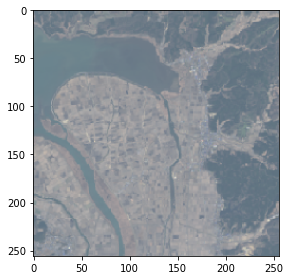

In [23]:
from skimage import io
from io import BytesIO
%matplotlib inline

def fetch_landsat8_image(sceneid, tile, color):
    url = 'https://gisapi.tellusxdp.com'
    url += '/blend/' + sceneid['tile_path'].format(**tile)
    
    r = requests.get(url, headers=HEADERS, params=color)
    return io.imread(BytesIO(r.content))

color = {
    'preset': 'true'
}
tile = {
    'x': 3645,
    'y': 1535,
    'z': 12
}
img_201404 = fetch_landsat8_image(scene_201404, tile, color)
io.imshow(img_201404)

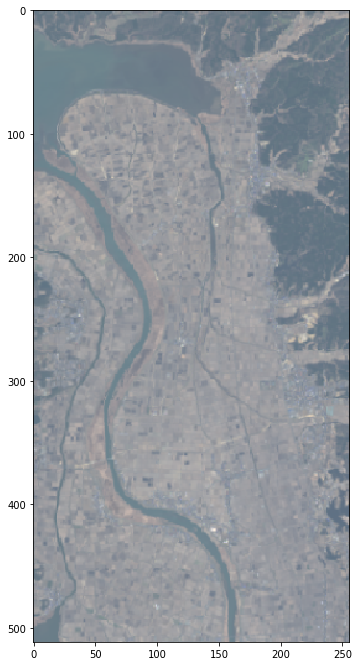

In [18]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def fetch_landsat8_images(sceneid, tile, size, color):
    col_img = []
    for x in range(size[0]):
        img = []
        for y in range(size[1]):
            tile_temp = tile.copy()
            tile_temp['x'] += x
            tile_temp['y'] += y
            img.append(fetch_landsat8_image(sceneid, tile_temp, color))
        col_img.append(np.vstack(img))
    return np.hstack(col_img)

color = {
    'preset': 'true'
}
tile = {
    'x': 3645,
    'y': 1535,
    'z': 12
}
img_201404 = fetch_landsat8_images(scene_201404, tile, (1, 2), color)
plt.figure(figsize=(5, 10))
io.imshow(img_201404)

## 画像から NDVI を計算する

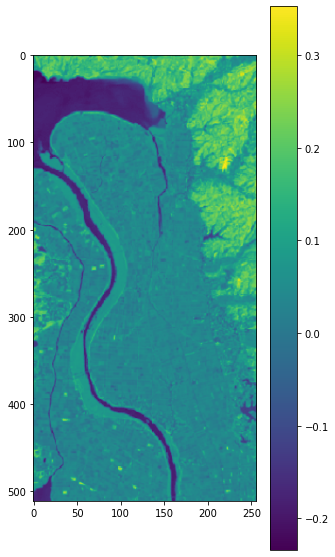

In [52]:
def calc_ndvi(red, nir):
    red = red.astype(np.float32)
    nir = nir.astype(np.float32)
    num = (nir - red).flatten()
    den = (nir + red).flatten()
    with np.errstate(divide='ignore', invalid='ignore'):
        ndvi = np.where(den != 0, num / den, np.nan)
    return ndvi.reshape(red.shape)
    
color = {
    'opacity': 1,
    'r': 4, # visible red light
    'g': 5, # NIR
    'b': 1,
    'rdepth': 1,
    'gdepth': 1,
    'bdepth': 1
}
tile = {
    'x': 3645,
    'y': 1535,
    'z': 12
}
img_blend_201404 = fetch_landsat8_images(scene_201404, tile, (1, 2), color)
img_ndvi_201404 = calc_ndvi(img_blend_201404[:, :, 0], img_blend_201404[:, :, 1])
plt.figure(figsize=(5, 10))
plt.imshow(img_ndvi_201404)
plt.colorbar()

0.6172714233398438


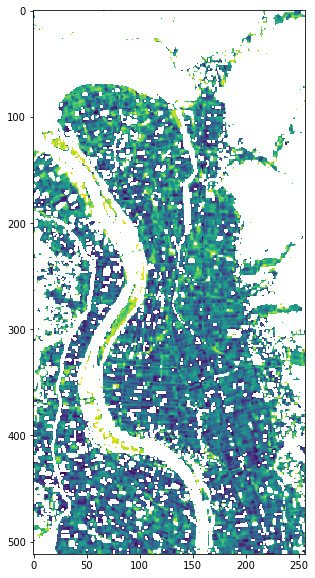

In [58]:
def filter_pixel_by_threshold(img, min_val, max_val):
    shape = img.shape
    filtered = np.where((min_val < img) & (img < max_val), img, np.nan)
    return filtered.reshape(shape)

def count_valid_pixel(img, min_val, max_val):
    filtered = np.where((min_val < img) & (img < max_val), 1, 0)
    return sum(filtered.flatten()) / len(img.flatten())

img_ndvi_201404_ext = filter_pixel_by_threshold(img_ndvi_201404, 0.01, 0.08)
plt.figure(figsize=(5, 10))
plt.imshow(img_ndvi_201404_ext)

print(count_valid_pixel(img_ndvi_201404, 0.01, 0.08))

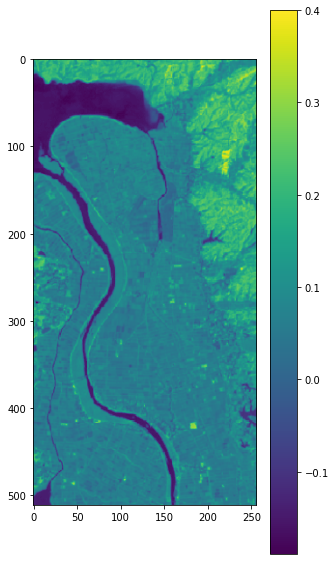

In [59]:
img_blend_201904 = fetch_landsat8_images(scene_201904, tile, (1, 2), color)
img_ndvi_201904 = calc_ndvi(img_blend_201904[:, :, 0], img_blend_201904[:, :, 1])
plt.figure(figsize=(5, 10))
plt.imshow(img_ndvi_201904)
plt.colorbar()

0.5083389282226562


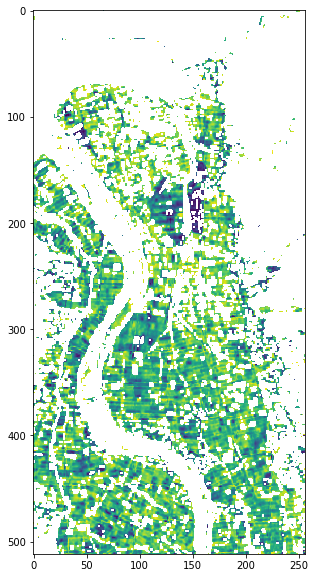

In [60]:
img_ndvi_201904_ext = filter_pixel_by_threshold(img_ndvi_201904, 0.01, 0.08)
plt.figure(figsize=(5, 10))
plt.imshow(img_ndvi_201904_ext)

print(count_valid_pixel(img_ndvi_201904, 0.01, 0.08))

## NDVI 画像から指定した領域の水田を抽出する

In [65]:
file_name = 'N03-22_02_220101.geojson'
with open(file_name) as f:
    data = json.load(f)

nakadomari_features = []
for d in data['features']:
    if d['properties']['N03_004'] == '中泊町':
        nakadomari_features.append(d)

print(len(nakadomari_features))

168


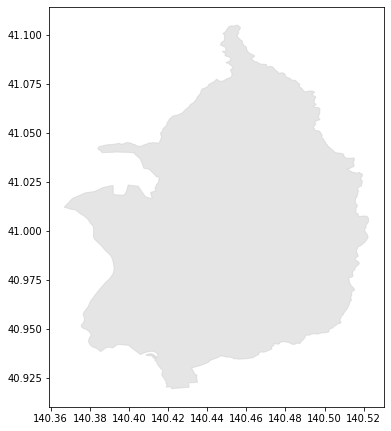

In [72]:
from descartes import PolygonPatch
fig = plt.figure(figsize=(6, 12))
ax = fig.gca()
ax.add_patch(PolygonPatch(nakadomari_features[0]['geometry'], fc='#cccccc', ec='#cccccc', alpha=0.5, zorder=2))
ax.axis('scaled')
plt.show()

In [165]:
import math

from skimage.draw import polygon

def num2deg(xtile, ytile, zoom):
    # https://wiki.openstreetmap.org/wiki/Slippy_map_tilenames#Python
    n = 2.0 ** zoom
    lon_deg = xtile / n * 360.0 - 180.0
    lat_rad = math.atan(math.sinh(math.pi * (1 - 2 * ytile / n)))
    lat_deg = math.degrees(lat_rad)
    return (lon_deg, lat_deg)
    
def calc_tile_bbox(tile, size):
    """
    タイル座標からバウンディングボックスを取得
    https://tools.ietf.org/html/rfc7946#section-5
    """
    right_top = num2deg(tile['x'] + size[0], tile['y'], tile['z'])
    left_bottom = num2deg(tile['x'], tile['y'] + size[1], tile['z'])
    return (left_bottom[0], left_bottom[1], right_top[0], right_top[1])
    
def world2pixel(bbox, size, lon, lat):
    """
    世界座標 (緯度経度) を画像座標 (ピクセル) に変換
    """
    dist = (
        (bbox[2] - bbox[0]) / size[0],
        (bbox[3] - bbox[1]) / size[1]
    )
    pixel = (
        int((lon - bbox[0]) / dist[0]),
        int((bbox[3] - lat) / dist[1])
    )
    return pixel

def get_polygon_image(points, bbox, dct_img_size):
    pixels = []
    img_size = (dct_img_size['width'], dct_img_size['height'])
    for p in points:
        pixels.append(world2pixel(bbox, img_size, p[0], p[1]))
    pixels = np.array(pixels)
    poly = np.ones((img_size[1], img_size[0]), dtype=np.uint8)
    rr, cc = polygon(pixels[:, 1], pixels[:, 0], poly.shape)
    poly[rr, cc] = 0
    return poly

/home/ubuntu/working/venv/lib/python3.10/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


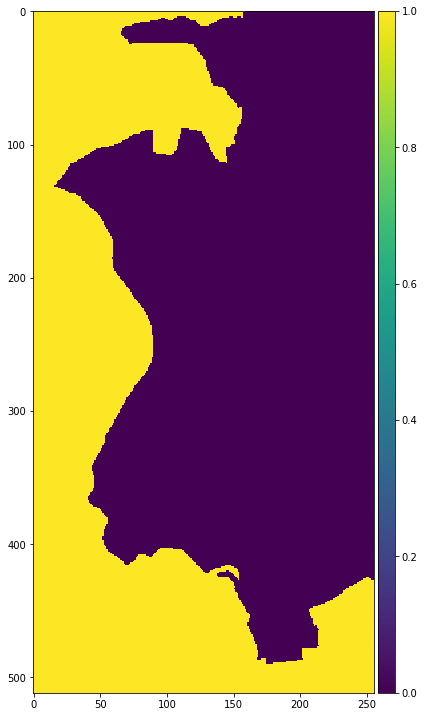

In [166]:
def calc_mask_image(features, bbox, px_size):
    ims = []
    for feature in features:
        points = feature['geometry']['coordinates'][0]
        ims.append(get_polygon_image(points, bbox, px_size))
    mask = np.where((ims[0] > 0), 0, 1)
    for i in range(1, len(ims)):
        mask = mask + np.where((ims[i] > 0), 0, 1)
    return np.where((mask > 0), 0, 1).astype(np.uint8)

bbox = calc_tile_bbox(tile, (1, 2))
px_size = {'height': img_ndvi_201904.shape[0], 'width': img_ndvi_201904.shape[1]}
mask = calc_mask_image(nakadomari_features, bbox, px_size)

plt.figure(figsize=(6, 12))
io.imshow(mask)

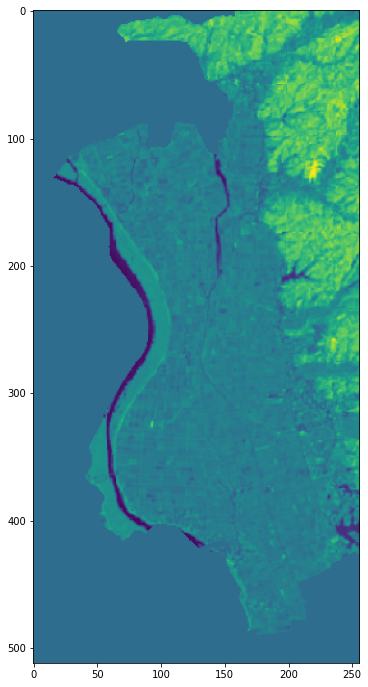

In [168]:
img_ndvi_201404_mask = np.where(mask != 1, img_ndvi_201404, 0)
plt.figure(figsize=(6, 12))
plt.imshow(img_ndvi_201404_mask)

In [169]:
img_ndvi_201404_ext_mask = np.where(mask != 1, img_ndvi_201404_ext, 0)
print(count_valid_pixel(img_ndvi_201404_ext_mask, 0.01, 0.08))

0.37535858154296875


0.29090118408203125


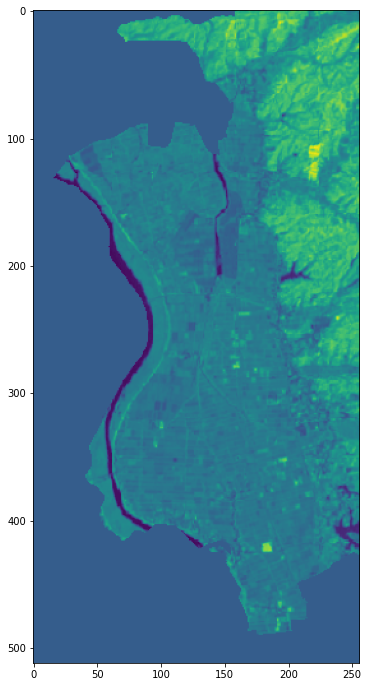

In [170]:
img_ndvi_201904_mask = np.where(mask != 1, img_ndvi_201904, 0)
plt.figure(figsize=(6, 12))
plt.imshow(img_ndvi_201904_mask)
img_ndvi_201904_ext_mask = np.where(mask != 1, img_ndvi_201904_ext, 0)
print(count_valid_pixel(img_ndvi_201904_ext_mask, 0.01, 0.08))